In [1]:
from src import contour_utils as cc
from src import experiment_utils as eu
from src import mv_gaussian as mv
from src import clf_utils as cu
from src import generate_melody as gm
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cross_validation import KFold
from sklearn import cross_validation
from sklearn import metrics
import sklearn
import pandas as pd
import numpy as np
import random
import glob
import os
import json
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from scipy.stats import boxcox

### Create train/test split

Splits are chosen such that each split contains unique artists.

In [2]:
mel_type=1

importlib.reload(eu)

with open('test_data/melody_trackids.json', 'r') as fhandle:
    track_list = json.load(fhandle)
track_list = track_list['tracks']

mdb_files, splitter = eu.create_splits(test_size=0.15)

dset_contour_dict, dset_annot_dict = \
        eu.compute_all_overlaps(track_list, meltype=2)

mdb_files, splitter = eu.create_splits(test_size=0.15)

for train, test in splitter:
    random.shuffle(train)
    n_train = len(train) - (len(test)/2)
    train_tracks = mdb_files[train[:n_train]]
    valid_tracks = mdb_files[train[n_train:]]
    test_tracks = mdb_files[test]
    break
    
train_contour_dict = {k: dset_contour_dict[k] for k in train_tracks}
valid_contour_dict = {k: dset_contour_dict[k] for k in valid_tracks}
test_contour_dict = {k: dset_contour_dict[k] for k in test_tracks}

train_annot_dict = {k: dset_annot_dict[k] for k in train_tracks}
valid_annot_dict = {k: dset_annot_dict[k] for k in valid_tracks}
test_annot_dict = {k: dset_annot_dict[k] for k in test_tracks}

Generating features...                                                                                      |
CelestialShore_DieForUs
melodia_contours/CelestialShore_DieForUs_MIX_vamp_melodia-contours_melodia-contours_contoursall.csv


OSError: File b'melodia_contours/CelestialShore_DieForUs_MIX_vamp_melodia-contours_melodia-contours_contoursall.csv' does not exist

### Split out features and compute labels

#### Compute overlap statistics of contours with partial overlap

In [4]:
importlib.reload(eu)
olap_stats, zero_olap_stats = eu.olap_stats(train_contour_dict)

#### Compute Labels using Overlap Threshold

In [5]:
OLAP_THRESH = 0.5
train_contour_dict, valid_contour_dict, test_contour_dict = \
    eu.label_all_contours(train_contour_dict, valid_contour_dict, \
                          test_contour_dict, olap_thresh=OLAP_THRESH)

In [6]:
X_train, Y_train = cc.pd_to_sklearn(train_contour_dict)
X_valid, Y_valid = cc.pd_to_sklearn(valid_contour_dict)
X_test, Y_test = cc.pd_to_sklearn(test_contour_dict)

### Score with Multivariate Gaussian

Transform data using boxcox transform, and fit multivariate gaussians.

In [7]:
X_train_boxcox, X_test_boxcox = mv.transform_features(X_train, X_test)
rv_pos, rv_neg = mv.fit_gaussians(X_train_boxcox, Y_train)

Compute melodiness scores on train and test set

In [8]:
M_train, M_test = mv.compute_all_melodiness(X_train_boxcox, X_test_boxcox, rv_pos, rv_neg)

Compute various metrics based on melodiness scores.

max prediction value = 480.961144402
min prediction value = 3.11328060769e-06


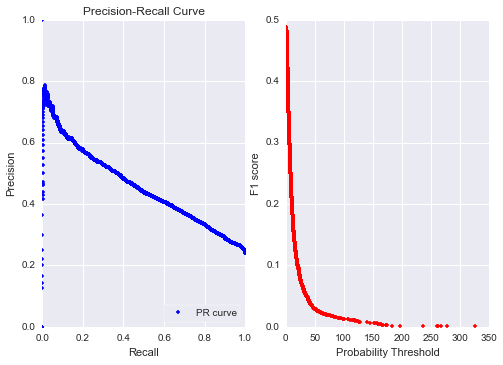

besth threshold = 0.910846244607
maximum achieved f score = 0.487888707038
{'test': {'auc score': 0.7238952696657619, 'confusion matrix': array([[10678,  4280],
       [ 1798,  2879]]), 'accuracy': 0.69045072574484334}, 'train': {'auc score': 0.81310072891815677, 'confusion matrix': array([[39890, 14215],
       [ 3331,  9435]]), 'accuracy': 0.73761421243887482}}


In [31]:
importlib.reload(mv)
importlib.reload(eu)
melodiness_scores = mv.melodiness_metrics(M_train, M_test, Y_train, Y_test)
best_thresh, max_fscore = eu.get_best_threshold(Y_test, M_test)
print ("besth threshold = %s" % best_thresh)
print ("maximum achieved f score = %s" % max_fscore)
print (melodiness_scores)

### Train Classifier

#### Cross Validation

training with max_depth=5
training with max_depth=10
training with max_depth=15
training with max_depth=20
training with max_depth=25
training with max_depth=30
training with max_depth=35
training with max_depth=40
training with max_depth=45
training with max_depth=50
training with max_depth=55
training with max_depth=60
training with max_depth=65
training with max_depth=70
training with max_depth=75
training with max_depth=80
training with max_depth=85
training with max_depth=90
training with max_depth=95


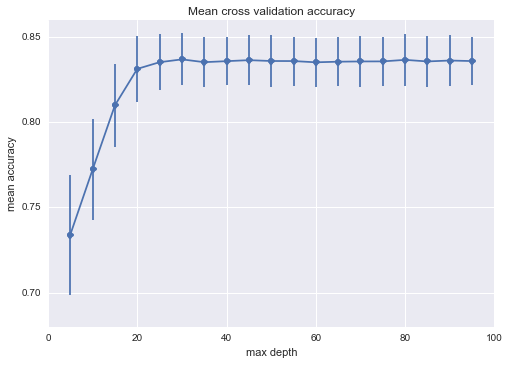

30
0.836820229515


In [306]:
importlib.reload(cu)
best_depth, max_cv_accuracy, plot_dat = cu.cross_val_sweep(X_train, Y_train)
print (best_depth)
print (max_cv_accuracy)

In [313]:
df = pd.DataFrame(np.array(plot_dat).transpose(), columns=['max depth', 'accuracy', 'std'])
df

max depth  accuracy       std
0           5  0.734026  0.035246
1          10  0.772233  0.029862
2          15  0.809903  0.024414
3          20  0.831242  0.019259
4          25  0.835160  0.016312
5          30  0.836820  0.015206
6          35  0.835175  0.014558
7          40  0.835773  0.013879
8          45  0.836357  0.014542
9          50  0.835863  0.015028
10         55  0.835833  0.014388
11         60  0.835100  0.014228
12         65  0.835459  0.014344
13         70  0.835609  0.015132
14         75  0.835639  0.014471
15         80  0.836536  0.015086
16         85  0.835609  0.014701
17         90  0.836147  0.014771
18         95  0.835833  0.014152

#### Training

In [33]:
clf = cu.train_clf(X_train, Y_train, best_depth)

#### Predict and Score

In [305]:
importlib.reload(cu)
P_train, P_valid, P_test = cu.clf_predictions(X_train, X_valid, X_test, clf)
clf_scores = cu.clf_metrics(P_train, P_test, Y_train, Y_test)
print (clf_scores['test'])

{'f1': array([ 0.86423152,  0.32573686]), 'recall': array([ 0.94431074,  0.22920676]), 'support': array([14958,  4677]), 'mcc': 0.24972490489355906, 'precision': array([ 0.79667231,  0.56272966]), 'auc score': 0.72591522244752704, 'confusion matrix': array([[14125,   833],
       [ 3605,  1072]]), 'accuracy': 0.77397504456327981}


#### Get threshold that maximizes F1 score

max prediction value = 1.0
min prediction value = 0.0


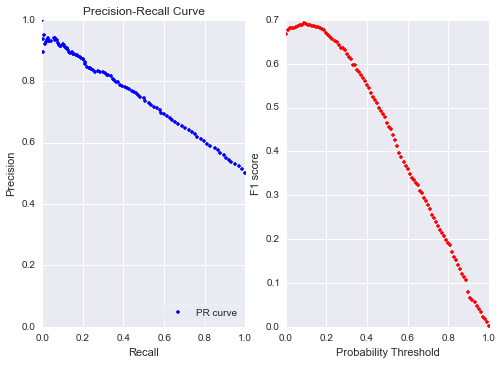

besth threshold = 0.09
maximum achieved f score = 0.691807179184


In [42]:
importlib.reload(eu)
best_thresh, max_fscore = eu.get_best_threshold(Y_valid, P_valid)
print ("besth threshold = %s" % best_thresh)
print ("maximum achieved f score = %s" % max_fscore)

### Generate Melody Output

#### Add predicted melody probabilites to test set contour data

In [43]:
for key in test_contour_dict.keys():
    test_contour_dict[key] = eu.contour_probs(clf, test_contour_dict[key])

#### Generate melody output using predictions

In [295]:
importlib.reload(gm)
mel_output_dict = {}
for i, key in enumerate(test_contour_dict.keys()):
    print (key)
    mel_output_dict[key] = gm.melody_from_clf(test_contour_dict[key], prob_thresh=best_thresh)

MusicDelta_Country1
Handel_TornamiAVagheggiar
Mozart_BesterJungling
Schubert_Erstarrung
MusicDelta_Britpop
SweetLights_YouLetMeDown
MusicDelta_Pachelbel
ChrisJacoby_PigsFoot
Mozart_DiesBildnis
MatthewEntwistle_TheArch
MusicDelta_ModalJazz
MatthewEntwistle_DontYouEver
Schumann_Mignon
MatthewEntwistle_FairerHopes
Wolf_DieBekherte
Debussy_LenfantProdigue
MatthewEntwistle_Lontano
ChrisJacoby_BoothShotLincoln
MatthewEntwistle_ImpressionsOfSaturn
MusicDelta_Gospel
HezekiahJones_BorrowedHeart
MatthewEntwistle_TheFlaxenField
MusicDelta_CoolJazz


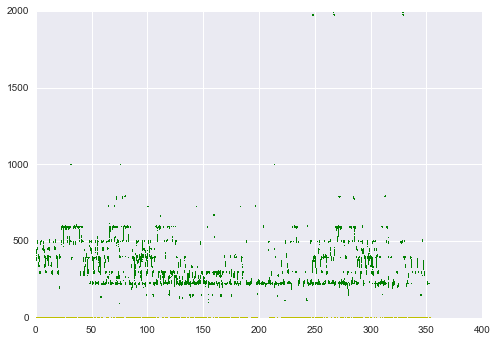

In [301]:
key="ChrisJacoby_PigsFoot"
df = mel_output_dict[key]
df_pos = df[df > 0]
df_zero = df[df == 0]
df_neg = df[df < 0]
plt.plot(df_pos.index, df_pos.values, ',g')
plt.plot(df_zero.index, df_zero.values, ',y')
plt.plot(df_neg.index, -1.0*df_neg.values, ',r')
plt.show()

### Score Melody Output

In [297]:
importlib.reload(gm)
mel_scores = gm.score_melodies(mel_output_dict, test_annot_dict)

Scoring...
MusicDelta_Country1
Handel_TornamiAVagheggiar
Mozart_BesterJungling
Schubert_Erstarrung
MusicDelta_Britpop
SweetLights_YouLetMeDown
MusicDelta_Pachelbel
ChrisJacoby_PigsFoot
Mozart_DiesBildnis
MatthewEntwistle_TheArch
HezekiahJones_BorrowedHeart
MatthewEntwistle_DontYouEver
Schumann_Mignon
MatthewEntwistle_FairerHopes
Wolf_DieBekherte
Debussy_LenfantProdigue
MatthewEntwistle_Lontano
ChrisJacoby_BoothShotLincoln
MatthewEntwistle_ImpressionsOfSaturn
MusicDelta_Gospel
MusicDelta_ModalJazz
MatthewEntwistle_TheFlaxenField
MusicDelta_CoolJazz


In [298]:
overall_scores = \
    pd.DataFrame(columns=['VR', 'VFA', 'RPA', 'RCA', 'OA'],
                 index=mel_scores.keys())
overall_scores['VR'] = \
    [mel_scores[key]['Voicing Recall'] for key in mel_scores.keys()]
overall_scores['VFA'] = \
    [mel_scores[key]['Voicing False Alarm'] for key in mel_scores.keys()]
overall_scores['RPA'] = \
    [mel_scores[key]['Raw Pitch Accuracy'] for key in mel_scores.keys()]
overall_scores['RCA'] = \
    [mel_scores[key]['Raw Chroma Accuracy'] for key in mel_scores.keys()]
overall_scores['OA'] = \
    [mel_scores[key]['Overall Accuracy'] for key in mel_scores.keys()]

overall_scores.describe()

VR        VFA        RPA        RCA         OA
count  23.000000  23.000000  23.000000  23.000000  23.000000
mean    0.839397   0.463562   0.533420   0.618318   0.520093
std     0.086113   0.137818   0.209234   0.175654   0.157097
min     0.683997   0.150386   0.167805   0.290410   0.236871
25%     0.753735   0.412517   0.355891   0.457874   0.410476
50%     0.854633   0.464505   0.552770   0.643999   0.485953
75%     0.895813   0.500122   0.665926   0.731187   0.616115
max     0.986070   0.806235   0.982873   0.983900   0.904193

In [299]:
overall_scores

VR       VFA       RPA       RCA  \
MusicDelta_Country1                   0.974351  0.471808  0.872682  0.879790   
Handel_TornamiAVagheggiar             0.683997  0.498484  0.443070  0.511351   
Mozart_BesterJungling                 0.777066  0.381579  0.552770  0.643999   
Schubert_Erstarrung                   0.897123  0.611121  0.486436  0.566834   
MusicDelta_Britpop                    0.971609  0.806235  0.629075  0.725026   
SweetLights_YouLetMeDown              0.876759  0.623655  0.570335  0.670301   
MusicDelta_Pachelbel                  0.836917  0.402566  0.348918  0.387921   
ChrisJacoby_PigsFoot                  0.744049  0.471997  0.351448  0.437976   
Mozart_DiesBildnis                    0.915567  0.456210  0.675468  0.742013   
MatthewEntwistle_TheArch              0.854633  0.444682  0.730082  0.775303   
MusicDelta_ModalJazz                  0.894502  0.453193  0.628026  0.704691   
MatthewEntwistle_DontYouEver          0.869578  0.498819  0.617738  0.707107   
Schumann_Mignon                       0.842151  0.501425  0.664896  0.715100   
MatthewEntwistle_FairerHopes          0.748062  0.150386  0.198983  0.436833   
Wolf_DieBekherte                      0.863327  0.251390  0.792345  0.821085   
Debussy_LenfantProdigue               0.900140  0.487432  0.666955  0.737348   
MatthewEntwistle_Lontano              0.716297  0.637789  0.167805  0.290410   
ChrisJacoby_BoothShotLincoln          0.753179  0.462179  0.322122  0.423695   
MatthewEntwistle_ImpressionsOfSaturn  0.889966  0.355654  0.447455  0.618842   
MusicDelta_Gospel                     0.986070  0.256470  0.982873  0.983900   
HezekiahJones_BorrowedHeart           0.806663  0.551878  0.326559  0.477772   
MatthewEntwistle_TheFlaxenField       0.749834  0.422467  0.432278  0.541751   
MusicDelta_CoolJazz                   0.754290  0.464505  0.360334  0.422263   

                                            OA  
MusicDelta_Country1                   0.714453  
Handel_TornamiAVagheggiar             0.457622  
Mozart_BesterJungling                 0.568571  
Schubert_Erstarrung                   0.448424  
MusicDelta_Britpop                    0.455033  
SweetLights_YouLetMeDown              0.485953  
MusicDelta_Pachelbel                  0.380483  
ChrisJacoby_PigsFoot                  0.400398  
Mozart_DiesBildnis                    0.637034  
MatthewEntwistle_TheArch              0.644499  
MusicDelta_ModalJazz                  0.600850  
MatthewEntwistle_DontYouEver          0.562468  
Schumann_Mignon                       0.622377  
MatthewEntwistle_FairerHopes          0.298197  
Wolf_DieBekherte                      0.778082  
Debussy_LenfantProdigue               0.609853  
MatthewEntwistle_Lontano              0.236871  
ChrisJacoby_BoothShotLincoln          0.362150  
MatthewEntwistle_ImpressionsOfSaturn  0.516064  
MusicDelta_Gospel                     0.904193  
HezekiahJones_BorrowedHeart           0.386750  
MatthewEntwistle_TheFlaxenField       0.471255  
MusicDelta_CoolJazz                   0.420553